# Multilayer Perceptron baseline
## Finally, it worked! Breadth > Depth

The cell outputs in this notebook may not be up-to-date because training is usually done without manual oversight by exporting the notebook as a script.

#### Regressor

hidden_layer_sizes=(2048, 1024, 256): f1-score \[0.46135 0.40327 0.12554 0.14801\] avg 0.28454

hidden_layer_sizes=(3072, 1024, 256): f1-score \[0.64766 0.63497 0.52672 0.36453\] avg **0.54347** (alt. run 0.26181)

hidden_layer_sizes=(4096, 1024, 256): f1-score \[0.58944 0.59615 0.46914 0.33229\] avg 0.49676

#### Classifier

hidden_layer_sizes=(2048, 1024, 256): fl-score \[0.67788 0.65749 0.47664 0.56250\] avg 0.59363

hidden_layer_sizes=(3072, 1024, 256): f1-score \[0.56571 0.56881 0.45669 0.41216\] avg 0.50084 (alt. run 0.64848)

hidden_layer_sizes=(3072, 1024, 1024, 256): f1-score \[0.69906 0.68421 0.54545 0.57143\] avg 0.62504

hidden_layer_sizes=(3072, 1024, 1024, 512, 256): f1-score \[0.77641 0.79132 0.60000 0.60976\] avg **0.69437**

hidden_layer_sizes=(4096, 1024, 256): f1-score \[0.62189 0.59155 0.46945 0.32911\] avg 0.50300


### Switched to TSNV

hidden_layer_sizes=(2816, 1024, 1024, 1024, 256): f1-score \[0.79548 0.81391 0.73973 0.72603\] average 0.76879

hidden_layer_sizes=(3072, 1024, 1024, 1024, 256): f1-score \[0.82739 0.87162 0.78970 0.77660\] average **0.81633** (alt. run 0.82256, alpha=0.01 => 0.82789)

hidden_layer_sizes=(3072, 1024, 1024, 1024): f1-score \[0.80282 0.81685 0.78571 0.76510\] average 0.79262

hidden_layer_sizes=(3072, 1024, 1024, 256): f1-score \[0.83931 0.84069 0.79808 0.76923\] average 0.81183 (alt. run 81299)

hidden_layer_sizes=(3072, 1024, 1024): f1-score \[0.65041 0.60197 0.52217 0.48366\] average 0.56455

hidden_layer_sizes=(3584, 1024, 1024, 1024, 256: f1-score \[0.80774  0.84734 0.76555 0.75524\] average 0.79397

hidden_layer_sizes=(4096, 1024, 1024, 1024, 256): f1-score \[0.79666 0.82218 0.83254 0.71084\] average 0.79055

In [1]:
import numpy as np
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### Data

In [3]:
# dataset = pd.read_pickle('../Dataset/baseline_dataset_tsnv_24.gz')
dataset = pd.read_pickle('../Dataset/baseline_dataset.gz')
pd.set_option("display.max.columns", None)
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45293 entries, 0 to 45292
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MM             45293 non-null  int64  
 1   DD             45293 non-null  int64  
 2   HH             45293 non-null  int64  
 3   LOW_IMPACT     45293 non-null  bool   
 4   MID_IMPACT     45293 non-null  bool   
 5   BIG_IMPACT     45293 non-null  bool   
 6   DIRECT_STRIKE  45293 non-null  bool   
 7   00LAT          45293 non-null  float32
 8   00LON          45293 non-null  float32
 9   00WIND         45293 non-null  int32  
 10  06LAT          45293 non-null  float32
 11  06LON          45293 non-null  float32
 12  06WIND         45293 non-null  int32  
 13  12LAT          45293 non-null  float32
 14  12LON          45293 non-null  float32
 15  12WIND         45293 non-null  int32  
 16  18LAT          45293 non-null  float32
 17  18LON          45293 non-null  float32
 18  18WIND

In [4]:
# imports
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split

# Constants
TRAIN_RATIO = 0.9
MAX_ITERS = 1000

In [6]:
# test-dev-train split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    # Y = np.asarray(dataframe.iloc[:,0:4]).astype(int)
    Y = np.asarray(dataframe.iloc[:,3:7]).astype(int)
    return X, Y

# train-dev-test splitting
splitDataset = separateDataset(dataset, TRAIN_RATIO)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 36686; Dev set size: 4077; Testing set size: 4530


### Tools

In [7]:
import joblib
from datetime import datetime

def save_sklearn_model_to_file(model, model_type, filename=None):
    '''Saves a sklearn model to file. Takes in the model, a name for the model and optionally a full filename.'''
    if filename == None:
        filename = "./models/baseline_model_{0}_{1}.skl".format(model_type, str(datetime.now().strftime("%Y-%m-%d %H-%M")))
        
    joblib.dump(model, filename)
    
    # to load a model: model = joblib.load(filename)

In [8]:
# finds the best decision thresholds and the corresponding F1 scores
# shows the precision-recall curve as well
def optimize_thresholds(clf, datasetX, datasetY):
    '''
    Takes in a classifier, an input set X and a target set Y; returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = clf.predict_proba(datasetX)
    best_thresholds = []
    best_f1_scores = []
    n_classes = len(clf.classes_)
    for i in range(n_classes):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))
    
    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
        
    return best_thresholds, best_f1_scores

# make predictions according to the given thresholds
def predictions_with_thresholds(clf, thresholds, datasetX):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = clf.predict_proba(datasetX)  
    n_classes = len(clf.classes_)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(n_classes):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [10]:
from scipy.special import expit

def regression_predict(regr, datasetX, method='clip'):
    '''
    Takes in a regressor, an input samples set X and optionally a method argument (must be either "sigmoid" or "clip");
    Returns predictions made by the regressor on X that have been rescaled to fall within [0,1] using the specified method.
    '''
    # method specifies how to handle inputs outside of 0-1 range: clip to 0 or 1, or pass through sigmoid
    preds = regr.predict(datasetX)
    if method == 'clip':
        preds = np.clip(preds, 0, 1)
    elif method == 'sigmoid':
        preds = expit(preds)
    return preds

def regressor_find_thresholds(regr, datasetX, datasetY, method='clip'):
    '''
    Takes in a regressor, an input set X, a target set Y and optionally a scaling method;
    returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    all_preds = regression_predict(regr, datasetX, method)
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

def regression_label(regr, datasetX, thresholds, method='clip'):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X and optionally a scaling method;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = regression_predict(regr, datasetX, method)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [11]:
# imports
from sklearn.neural_network import MLPRegressor, MLPClassifier

### Regressor

(3072, 1024, 256): average f1 0.54347       
(3072, 1024, 1024, 1024, 256): average f1 probably disastrous

MLP regressors are likely unsuitable

In [20]:
mlp_regr = MLPRegressor(
    hidden_layer_sizes=(3072, 1024, 1024, 1024, 256),
    batch_size=512,
    alpha=0.01,
    max_iter=MAX_ITERS,
    shuffle=True,
    verbose=True,
    random_state=42
)

mlp_regr = mlp_regr.fit(train_X, train_Y)

Iteration 1, loss = 14.75024329
Iteration 2, loss = 0.08492585
Iteration 3, loss = 0.05610611
Iteration 4, loss = 0.05792739
Iteration 5, loss = 0.05819284
Iteration 6, loss = 0.05174721
Iteration 7, loss = 0.05021901
Iteration 8, loss = 0.05063860
Iteration 9, loss = 0.05129845
Iteration 10, loss = 0.04806291
Iteration 11, loss = 0.04787761
Iteration 12, loss = 0.04757031
Iteration 13, loss = 0.04728702
Iteration 14, loss = 0.04707625
Iteration 15, loss = 0.04733981
Iteration 16, loss = 0.04727447
Iteration 17, loss = 0.04608255
Iteration 18, loss = 0.04575512
Iteration 19, loss = 0.04547080
Iteration 20, loss = 0.04553568
Iteration 21, loss = 0.04538387
Iteration 22, loss = 0.04498728
Iteration 23, loss = 0.04458605
Iteration 24, loss = 0.04442632
Iteration 25, loss = 0.04437355
Iteration 26, loss = 0.04422562
Iteration 27, loss = 0.04388001
Iteration 28, loss = 0.04628849
Iteration 29, loss = 0.04411449
Iteration 30, loss = 0.04372437
Iteration 31, loss = 0.04342731
Iteration 32, lo

Iteration 253, loss = 0.01702976
Iteration 254, loss = 0.01726074
Iteration 255, loss = 0.01687828
Iteration 256, loss = 0.01690149
Iteration 257, loss = 0.01659942
Iteration 258, loss = 0.01594122
Iteration 259, loss = 0.01628195
Iteration 260, loss = 0.01652797
Iteration 261, loss = 0.01703423
Iteration 262, loss = 0.01673236
Iteration 263, loss = 0.01569915
Iteration 264, loss = 0.01620148
Iteration 265, loss = 0.01662544
Iteration 266, loss = 0.01587135
Iteration 267, loss = 0.01616655
Iteration 268, loss = 0.01535302
Iteration 269, loss = 0.01611028
Iteration 270, loss = 0.01529769
Iteration 271, loss = 0.01603482
Iteration 272, loss = 0.01514365
Iteration 273, loss = 0.01531903
Iteration 274, loss = 0.01554437
Iteration 275, loss = 0.01585334
Iteration 276, loss = 0.01627159
Iteration 277, loss = 0.01497305
Iteration 278, loss = 0.01450347
Iteration 279, loss = 0.01565199
Iteration 280, loss = 0.01512405
Iteration 281, loss = 0.01614275
Iteration 282, loss = 0.01438375
Iteration 

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Best Threshold=0.47606, F-Score=0.69748
Best Threshold=0.45027, F-Score=0.70125
Best Threshold=0.40649, F-Score=0.59330
Best Threshold=0.27487, F-Score=0.47514


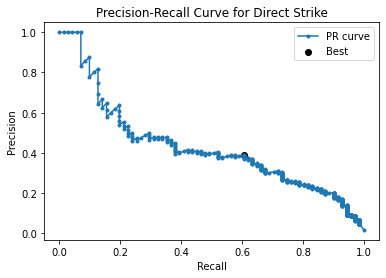

In [13]:
preds = regression_predict(mlp_regr, dev_X)
best_thresholds, best_f1_scores = regressor_find_thresholds(mlp_regr, dev_X, dev_Y)

In [14]:
preds = regression_label(mlp_regr, dev_X, best_thresholds)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.73156   0.66310   0.69565       374
           1    0.66781   0.73308   0.69892       266
           2    0.52586   0.66304   0.58654        92
           3    0.38532   0.59155   0.46667        71

   micro avg    0.63785   0.67995   0.65823       803
   macro avg    0.57764   0.66269   0.61195       803
weighted avg    0.65626   0.67995   0.66399       803
 samples avg    0.06757   0.07350   0.06728       803



In [15]:
print(mlp_regr.score(train_X, train_Y))
print(mlp_regr.score(dev_X, dev_Y))

0.4830675747574118
0.383707748984343


In [14]:
save_sklearn_model_to_file(mlp_regr, "mlpregr")

In [16]:
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(3072, 1024, 1024, 1024, 256),
    batch_size=512,
    alpha=0.01,
    max_iter=MAX_ITERS,
    shuffle=True,
    verbose=True,
    random_state=42
)

mlp_clf = mlp_clf.fit(train_X, train_Y)

Iteration 1, loss = 2.19299927
Iteration 2, loss = 0.71405397
Iteration 3, loss = 0.68443129
Iteration 4, loss = 0.65849089
Iteration 5, loss = 0.64869001
Iteration 6, loss = 0.65767443
Iteration 7, loss = 0.64435090
Iteration 8, loss = 0.63556792
Iteration 9, loss = 0.64348854
Iteration 10, loss = 0.63039427
Iteration 11, loss = 0.62911193
Iteration 12, loss = 0.62900580
Iteration 13, loss = 0.61720098
Iteration 14, loss = 0.62790542
Iteration 15, loss = 0.62271668
Iteration 16, loss = 0.62045057
Iteration 17, loss = 0.60945564
Iteration 18, loss = 0.61035001
Iteration 19, loss = 0.59769126
Iteration 20, loss = 0.61402672
Iteration 21, loss = 0.60349351
Iteration 22, loss = 0.59042426
Iteration 23, loss = 0.59558604
Iteration 24, loss = 0.59173804
Iteration 25, loss = 0.58976217
Iteration 26, loss = 0.58463908
Iteration 27, loss = 0.60627271
Iteration 28, loss = 0.58100658
Iteration 29, loss = 0.58558944
Iteration 30, loss = 0.57848325
Iteration 31, loss = 0.56545045
Iteration 32, los

Best Threshold=0.36290, F-Score=0.80965
Best Threshold=0.24985, F-Score=0.81720
Best Threshold=0.51735, F-Score=0.73143
Best Threshold=0.18072, F-Score=0.69182


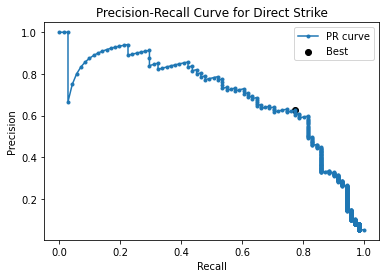

In [17]:
best_thresholds, best_f1_scores = optimize_thresholds(mlp_clf, dev_X, dev_Y)

In [18]:
preds = predictions_with_thresholds(mlp_clf, best_thresholds, dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.81132   0.80481   0.80805       374
           1    0.78007   0.85338   0.81508       266
           2    0.76829   0.68478   0.72414        92
           3    0.62069   0.76056   0.68354        71

   micro avg    0.77617   0.80324   0.78947       803
   macro avg    0.74509   0.77589   0.75770       803
weighted avg    0.77918   0.80324   0.78976       803
 samples avg    0.08799   0.09006   0.08677       803



In [19]:
print(mlp_clf.score(train_X, train_Y))
print(mlp_clf.score(dev_X, dev_Y))

0.9890421414163441
0.9374540103016924


In [ ]:
save_sklearn_model_to_file(mlp_clf, "mlpclf")